In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [ ]:
train_loc = '/content/drive/MyDrive/train'
test_loc = '/content/drive/MyDrive/val'

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(180,180))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(180,180))

Found 5515 images belonging to 8 classes.
Found 1383 images belonging to 8 classes.


In [ ]:
diagnosis_csv = '/content/drive/MyDrive/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv'
diagnosis = pd.read_csv(diagnosis_csv, names=['pId', 'diagnosis'])
diagnosis.head()

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [ ]:
categories = diagnosis['diagnosis'].unique()
categories

array(['URTI', 'Healthy', 'Asthma', 'COPD', 'LRTI', 'Bronchiectasis',
       'Pneumonia', 'Bronchiolitis'], dtype=object)

In [ ]:
rn = ResNet50(weights='imagenet')
rn.summary()

x  = rn.output

102967424/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [ ]:
from keras import backend as K
K.clear_session()


In [ ]:
import tensorflow as tf


In [ ]:
y_train = diagnosis['diagnosis']


In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense

In [ ]:
height = 128
width = 128
channels = 3

In [ ]:
rn_input = rn.input

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming diagnosis is your dataframe
label_encoder = LabelEncoder()
diagnosis['encoded_diagnosis'] = label_encoder.fit_transform(diagnosis['diagnosis'])

# Now 'encoded_diagnosis' column contains numeric labels
y_train = diagnosis['encoded_diagnosis']

# Assuming num_classes is the number of unique classes
num_classes = len(diagnosis['encoded_diagnosis'].unique())






In [ ]:
from keras.utils import to_categorical

# Assuming y_train is your target variable
# Convert to one-hot encoded format
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)


In [ ]:
with tf.name_scope("my_model"):
    x = Dense(256, activation='relu')(rn_input)
    predictions = Dense(8, activation='softmax', name='predictions')(x)


In [ ]:
model = Model(inputs=rn_input, outputs=predictions)

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-25:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)

Layer 'input_1' is trainable
Layer 'dense' is trainable
Layer 'predictions' is trainable


In [ ]:
opt = Adam(lr=0.0000001)
model.compile(optimizer=opt, loss=categorical_crossentropy,
              metrics=['accuracy', 'mae'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 dense (Dense)               (None, 224, 224, 256)     1024      
                                                                 
 predictions (Dense)         (None, 224, 224, 8)       2056      
                                                                 
Total params: 3080 (12.03 KB)
Trainable params: 3080 (12.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
checkpoint = ModelCheckpoint("rn_base_res.h5", monitor='val_accuracy', verbose=2,
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=2, mode='auto')

In [ ]:
counter = Counter(traindata.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1149.0,
 1: 55.373493975903614,
 2: 35.90625,
 3: 1.0,
 4: 17.883268482490273,
 5: 183.84,
 6: 20.157894736842106,
 7: 23.690721649484537}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

# Create a Sequential model
model = Sequential()

# Add layers to your model
model.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

np.random.seed(42)
tf.random.set_seed(42)

# Now you can train the model
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size,
                 validation_data=testdata, validation_steps=testdata.samples//testdata.batch_size,
                 epochs=7, callbacks=[checkpoint])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 253472)            0         
                                                                 
 dense_4 (Dense)             (None, 8)                 2027784   
                                                                 
Total params: 2028680 (7.74 MB)
Trainable params: 2028680 (7.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/7
172/172 [==============================] - ETA: 0s - loss: 209.8560 - ac

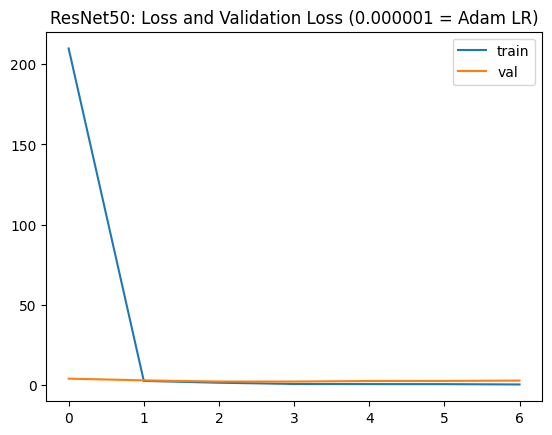

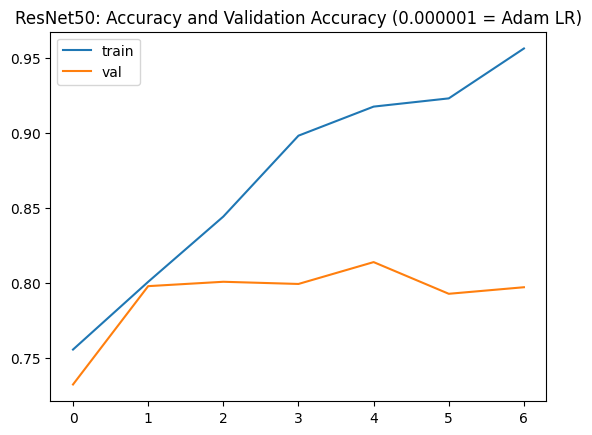

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('ResNet50: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('ResNet50: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()


